# Enterprise Deep Learning with TensorFlow: OpenSAP
# Week 04 - Convolutional Neural Networks

## SAP Innovation Center Network
```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

### Prerequisites


For this notebook, we require the 'German Traffic Sign Recognition Benchmark (GTSRB)' dataset.
This dataset can be downloaded from here:
    http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip

Please extract the dataset into your working directory (you can also set your working directory further below).

We require the following python packes:

    tensorflow==1.3
    
    pillow
    
    matplotlib

### Overview

```
This notebook makes use of Tensorflow's new Estimator API and the new Dataset API.
Both APIs are widely used within e.g. Google or SAP. They simplify and standardize model building.

The Estimator API.

tf.estimator.Estimator:
An 'estimator' takes as input some 'model' function along with some custom parameters.
It wraps the training loop, evaluation loop & prediction stage.

  def model_fn(features, labels, mode, params):
     ...
     setup network graph for training, evaluation, and prediction mode
     define loss & training operator
     define what the network outputs / predicts
     define accuracy measures

     return tf.estimator.EstimatorSpec(loss, mode, predictions, train_op, eval_metric_ops, training_hooks)

  estimator = tf.estimator.Estimator(model_fn, params, config)


  def train_input_fn():
      return features, labels   # tensors

  estimator.train(train_input_fn)


  def validation_input_fn():
      return features, labels   # tensors

  estimator.evaluate(validation_input_fn)

  result = estimator.predict(predict_input_fn)

  for output in result:

      do_something_with(output)
```

### Loading the necessary modules

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
from random import shuffle
import os
import glob
# Image processing
from PIL import Image

# We use matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


### Setting up our environment

In [2]:
# Working Directory
WORK_DIR = os.path.curdir
# GTSRB sample dir (by default this is at same location as the working dir)
# The samples can be downloaded from http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
GTSRB_DIR = WORK_DIR + '/GTSRB/Final_Training/Images/'
# Our output/log directory
LOG_DIR = WORK_DIR + '/cnn_output'
# The number of training iterations
TRAINING_STEPS = 50000
# The number of training features we are going to train in parallel
# (to speed things up)
BATCH_SIZE = 10
# How often do we want to do screen / file log output
PRINT_STEPS = TRAINING_STEPS / 100
# Our learning rate.
# If too large, training can become unstable.
# If too small, training might converge too slowly or not to an optimum.
LEARNING_RATE = 1e-1
# Momentum smoothes out sudden changes in the gradient
MOMENTUM = 0.1
# The input image resolution (all input samples will be interpolated to this resolution)
IMAGE_RES = [48,48]
# Shall we first convert ppm files to jpg?
CONVERT_PPM = False
# Every how many training steps do we want to measure the error on the validation data
VALIDATE_EVERY = 1000

# A custom dictionary of parameters.
params = { 'log_dir' : LOG_DIR,
           'learning_rate' : LEARNING_RATE,
           'momentum': MOMENTUM,
           'base_channels': 8,
           'weight_decay': 1e-5,
           'print_steps' : PRINT_STEPS,
           'save_summary_steps' : PRINT_STEPS,
           'save_checkpoint_steps' : VALIDATE_EVERY,
           'validate_every' : VALIDATE_EVERY,
           'train_steps' : TRAINING_STEPS
           }

### Preparing the dataset
In this exercise we will use the German Traffic Sign Recognition Benchmark (GTSRB) dataset.
The samples can be downloaded from http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip.

Since tensorflow cannot decode the images in their provided ppm format, we must first convert all the images to jpg format. 

Conversion needs to be done only once so please modify the CONVERT_PPM flag above to control whether or not you want to convert the dataset.

In [3]:
# Small helper routine to convert ppm images to jpg images
# Only required to be executed once
def convert_from_ppm_to_jpg(directory):

    files = sorted(glob.glob(directory + '/*/*.ppm'))
    

    for filename in files:
        image = Image.open(filename)
        #image.save(filename.split('.')[0]+'.jpg')
        image.save(filename[:-4]+'.jpg') #SK modified to comply with previous modification

if CONVERT_PPM is True:
    convert_from_ppm_to_jpg(GTSRB_DIR)
    
print(os.getcwd()) 

/notebooks


### Taking a first look at the dataset
You should run (Control + Enter) the following cell several times to get a feeling of the different images in the dataset. Note that the images do not share a common size/resolution.


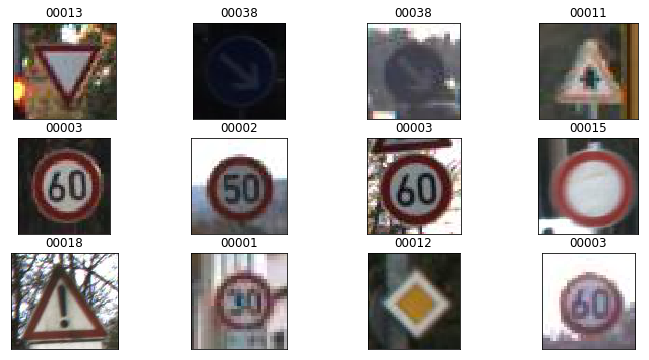

In [4]:
# show some images from the dataset
# executing this cell you will see 4 random images
# from out dataset and their respective labels

num_images = 12

assert num_images % 4 == 0, "Please choose a number of images that divides by 4."

files = sorted(glob.glob(GTSRB_DIR+'/*/*.jpg'))
shuffle(files)
files = files[:num_images]
labels = [filename.split(os.sep)[-2] for filename in files]

fig, axs = plt.subplots((num_images // 4), 4, figsize=(12,6))
axs = axs.ravel()
count = 0
for file, label in zip(files, labels):
    img=mpimg.imread(file)
    axs[count].set_title(label)
    axs[count].imshow(img)
    axs[count].set_xticks([])
    axs[count].set_yticks([])
    count += 1 


### Image and label retrieval helper functions

In [ ]:
# We have the original GTSRB training data.
# To also have something for testing, we split the training data
# into training + validation sets.
# We take as input the parent directory of the GTSRB training images,
# and we return two list
def get_sample_filenames(directory, train_fraction = 0.8):

    files = sorted(glob.glob(directory+'/*/*.jpg'))

    # We need to shuffle so that all classes are (equally) represented
    shuffle(files)

    num_train_samples = int(len(files) * train_fraction)

    train_set = files[:num_train_samples]
    valid_set = files[num_train_samples:]

    return train_set, valid_set    


# Extracts a label from the filename (the files are grouped in )
def get_labels(filenames):

    return np.asarray([np.int32(filename.split(os.sep)[-2]) for filename in filenames])



# This routine takes a sinput a filename and returns the associated image and label.
def load_sample(filename, target_res):

    # Load image data
    image_data = tf.read_file(filename)

    # convert data into image
    image_decoded = tf.image.decode_jpeg(image_data, channels=3)
    # resize image
    image_decoded = tf.image.resize_images(image_decoded, target_res, method=tf.image.ResizeMethod.BILINEAR)
    # make sure type is uint8 (note that this part of the graph is still on CPU/RAM)
    # If we convert to float32 here, we would need to transfer more data to GPU which is slower!
    image_decoded = tf.cast(image_decoded, tf.uint8)

    return image_decoded

### Some Tensorflow helper classes and functions

In [6]:
# This is a simple Tensorflow 'hook' to help a bit with simple text ascii output.
class OutputHook(tf.train.SessionRunHook):

    def __init__(self, name, log_dir=None, logged_tensors={}, save_steps=100):

        self._logdir = log_dir
        self._logged_tensors = logged_tensors
        self._save_steps = save_steps
        self._name = name

    def begin(self):
        # Let's get the 'global_step' tensor.
        # The Tensorflow estimator will create this tensor to log / control
        # the training.
        # We need it to know at which training step we are.
        self._global_step_tensor = tf.train.get_global_step()
        self._logged_tensors['step'] = self._global_step_tensor

    def before_run(self, run_context):
        """ This routine is executed by Tensorflow before each training step.
            It returns a dictionary of tensors that shall be
            evaluated by the actual training step (i.e. the implicit session.run call).
        """
        return tf.train.SessionRunArgs(fetches=self._logged_tensors)

    def after_run(self, run_context, run_values):
        """ This routine is run directly after a training step (i.e. a session.run call).
            Since we returned a 'SessionRunArgs' object in the before_run routine above,
            This routine will receive a dictionary of results of the evaluated tensors (in "run_values").
            Here, we are interested in outputting those results to a text ascii file.
        """
        
        if run_values.results['step'] % self._save_steps:
            return

        fp = open(self._logdir+'/'+self._name+'.txt', 'a')

        fp.write(str(run_values.results['step']))
        del run_values.results['step']

        for key in run_values.results:
            fp.write(' '+str(run_values.results[key]))
        fp.write('\n')
        fp.close()

In [7]:
# This 'validation hook' is executed whenever we have a new checkpoint
# (i.e. complete new set of model parameters) available
class ValidationHook(tf.train.SessionRunHook):

    def __init__(self, estimator, input_fn, validate_every):

        self._estimator = estimator
        self._input_fn = input_fn
        self._logdir = estimator._model_dir
        self._latest_path = None
        self._validate_every = validate_every
        self._last_validation_step = -validate_every

    def begin(self):
        # Let's get the 'global_step' tensor.
        # The Tensorflow estimator will create this tensor to log / control
        # the training.
        # We need it to know at which training step we are.
        self._global_step_tensor = tf.train.get_global_step()

    def before_run(self, run_context):
        """ This routine is executed by Tensorflow before each training step.
            It returns a dictionary of tensors that shall be
            evaluated by the actual training step (i.e. the implicit session.run call).
        """
        return tf.train.SessionRunArgs(fetches=self._global_step_tensor)

    def after_run(self, run_context, run_values):
        """ This routine is run directly after a training step (i.e. a session.run call).
            Since we returned a 'SessionRunArgs' object in the before_run routine above,
            This routine will receive a dictionary of results of the evaluated tensors (in "run_values").
            Here, we are interested in computing the accuracy over the validation dataset, i.e.
            we execute the estimator.evaluate method.
        """

        global_step_value = run_values.results

        if global_step_value-self._last_validation_step < self._validate_every:
            return

        # Check if any checkpoint exists. Checking this EVERY training step would be slow.
        # That's why we have the step above
        latest_path = tf.train.latest_checkpoint(self._logdir)

        # Only execute if there is a new checkpoint
        if not latest_path or latest_path == self._latest_path:
            return

        self._latest_path = latest_path
        self._last_validation_step = global_step_value

        output = self._estimator.evaluate(self._input_fn)
        tf.logging.info("VAL val-loss = {:.5f}, val-acc = {:.5f}, step = {}".format(output["loss"],
                                                                                    output["accuracy"],
                                                                                    global_step_value))
        # Write validation result to file as well
        fp = open(self._logdir + '/validation.txt', 'a')
        fp.write(str(global_step_value))
        fp.write(' ' + str(output['loss'])+' '+str(output['accuracy'])+'\n')
        fp.close()

### We use Tensorflow's dataset API to provide us with the network input

In [34]:
# This routine returns a (features, labels) tuple
# of tensors. These tensors are fed by Tensorflow's dataset API using the
# train_samples data set generated above.
def input_fn(sample_set, mode=tf.estimator.ModeKeys.TRAIN):


    num_samples = len(sample_set)


    def _input():

        # if we are not in 'prediction' mode, we actrually have access to labels as well!
        if mode != tf.estimator.ModeKeys.PREDICT:
            
            # Get the labels from filenames
            labels = get_labels(sample_set)

            # We use list of (file name, label) tuples to generate a dataset.
            dataset = tf.contrib.data.Dataset.from_tensor_slices((tf.constant(sample_set), tf.constant(labels)))

            # Call mapping function to map filenames to (image, label)
            dataset = dataset.map(lambda image, label : (load_sample(image, target_res=IMAGE_RES), label),
                                  # Load images on multiple threads in parallel and preload up to 500 samples
                                  num_threads=4, output_buffer_size=500)
        else:
            # We are not in prediction mode and so have no labels!
            dataset = tf.contrib.data.Dataset.from_tensor_slices(tf.constant(sample_set))

            # Call mapping function to map filenames to image
            dataset = dataset.map(lambda image : load_sample(image, target_res=IMAGE_RES),
                                  # Load images on multiple threads in parallel and preload up to 500 samples
                                  num_threads=4, output_buffer_size=500)
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            # Let's repeat samples from the dataset indefinitely
            dataset = dataset.repeat()
            # Let's shuffle training samples. This will improve training because the network will
            # see individual training samples in random order and grouped in random batches.
            dataset = dataset.shuffle(num_samples)
            # Let's finally batch individual samples to groups of BATCH_SIZE samples
            # This is what the network will receive as input.
            dataset = dataset.batch(BATCH_SIZE)

            # Finally, create a one shot iterator for the dataset.
            # The iterator is used for accessing the individual elements from the dataset.
            # (i.e. the randomly shuffled batches of samples) from the dataset
            iterator = dataset.make_one_shot_iterator()
        else:
            # Let's finally batch individual samples to groups of BATCH_SIZE samples
            # This is what the network will receive as input.
            dataset = dataset.batch(BATCH_SIZE)

            # Finally, create a one shot iterator for the dataset.
            # The iterator is used for accessing the individual elements from the dataset.
            # (i.e. the randomly shuffled batches of samples) from the dataset
            iterator = dataset.make_one_shot_iterator() #initializable_iterator()
       
        # Get the shuffled and batched samples from the dataset.
        # At this point we are having tensors which can be directly used in any network graph.
        if mode != tf.estimator.ModeKeys.PREDICT:
            features, labels = iterator.get_next()
        else:
            features, labels = (iterator.get_next(), None)
            
        return (features, labels)

    return _input

### The Convolutional Neural Network
The following function defines our network architecture. 


In [12]:
tf.reset_default_graph()
def architecture(features,  params, mode, scope = "my_model"):
    # Tensorflow supports two data formats:
    #  1) (minibatch_size, height, width, channels) aka 'NHWC'
    #  2) (minibatch_size, channels, height, width) aka 'NCHW'
    # The former format is Tensorflow's default format.
    # The latter format, however, is computationally more efficient when making heavy use
    # of convolutions!
    # When running on CPU, one must select 'NHWC'!
    data_format = 'NHWC'

    batch_norm_params = {
        'data_format': data_format,
        'is_training': True if mode == tf.estimator.ModeKeys.TRAIN else False,
        'decay': 0.9,
        'epsilon': 1e-4,
        'scale': False,  # Scaling by Gamma can be disabled if activation function is ReLU
        'updates_collections': tf.GraphKeys.UPDATE_OPS,   # The running mean & variance need to be updated during training
        'fused': True  # This significantly speeds things up!!
    }

    # The first thing we need to do:
    # Convert the input features from NHWC to NCHW format!
    if data_format == 'NCHW':
        features = tf.transpose(features, perm=[0, 3, 1, 2])
    # convert to floating point!
    features = tf.cast(features, tf.float32)

    # Let's get the height & width of the input images
    features_shape = features.get_shape().as_list()
    if data_format == 'NCHW':
        feature_height, feature_width = features.shape[2:]
    else:
        feature_height, feature_width = features.shape[1:3]

    # The number of 'base' channels for our network
    base_channels = params['base_channels']
    # GTSRB has 43 classes
    num_classes = 43
    
    end_points_collection = "end_points"
    # Let's set some default options for all layers that we are going to use inside the 'with' block!
    # First, we will set default arguments for the convolutional layer
    with slim.arg_scope(
            # We want to set default arguments for all conv2d layers
            [slim.conv2d],
            # We want to use 3x3 convolutions
            kernel_size = [3,3],
            # Let's regularize our weights!
            weights_regularizer=slim.regularizers.l2_regularizer(params['weight_decay']),
            # Weights shall be initialized using He's method
            weights_initializer=slim.initializers.variance_scaling_initializer(mode='FAN_OUT'),
            # We use ReLU activation functions after each convolution
            activation_fn=slim.nn_ops.relu,
            # Let's also activate batch normalization!
            normalizer_fn=slim.batch_norm,
            normalizer_params = batch_norm_params,
            # The padding shall be such that the outcome of a convolution has same resolution
            # as the input
            padding = 'SAME',
            # Set the data format
            data_format = data_format,
            # The stride of the convolutions
            stride = 1,
            outputs_collections=end_points_collection
            ):

        # Next, let's also have some default arguments for batch normalization layer
        with slim.arg_scope([slim.batch_norm], **batch_norm_params):

            # ...and also, some default arguments for the max-pooling layer
            with slim.arg_scope([slim.max_pool2d],
                                padding='SAME',
                                data_format = data_format,
                                # Stride 2 and kernel 2 pooling
                                # results in downsampling by a factor of 2
                                stride=[2,2],
                                kernel_size=[2,2],
                                outputs_collections=end_points_collection) as arg_sc:

                # Now let's setup our network...

                # The first convolutional 'block'.
                # These convolutions all operate at the same resolution and produce
                # the same number of output channels.
                # Since we have specified kernel_size, activation function, etc already as default arguments above,
                # we do not need to repeat that here!
                net = slim.conv2d(features, base_channels, scope='conv11')
                net = slim.conv2d(net, base_channels, scope='conv12')
                net = slim.conv2d(net, base_channels, scope='conv13')

                # Let's reduce the resolution by a factor of 2. We do so by applying the max-pooling operation.
                # Again, notice that we have set default arguments above, so no need to state kernel_size
                # and stride.
                net = slim.max_pool2d(net)

                # Let's have another convolutional block.
                # Note that we are now operating at half the resolution (due to the pooling),
                # but we are doubling the number of output channels of each convolution.
                # This simple yet effective design was introduced by the VGG network
                # (halfing resolution, doubling channels).
                net = slim.conv2d(net, 2*base_channels, scope='conv21')
                net = slim.conv2d(net, 2*base_channels, scope='conv22')
                net = slim.conv2d(net, 2*base_channels, scope='conv23')

                # ... and pool again
                net = slim.max_pool2d(net)

                # ... next convolutional block (same game as before)
                net = slim.conv2d(net, 4*base_channels, scope='conv31')
                net = slim.conv2d(net, 4*base_channels, scope='conv32')
                net = slim.conv2d(net, 4*base_channels, scope='conv33')

                # Global pooling: we average each channel in the convolution
                # This will leave us with a tensor of shape (N, 4*base_channels, 1,1)
                net = slim.avg_pool2d(net, kernel_size=[feature_height//4, feature_width//4], 
                                      data_format=data_format, scope="avg_pooling", 
                                      outputs_collections=end_points_collection)
                # Let's convert the tensor to shape (N, 4*base_channels)
                net = slim.flatten(net)

                # Let's have a fully connected layer
                net = slim.fully_connected(net, num_outputs=100, activation_fn=tf.nn.relu, scope="fc1",
                                          outputs_collections=end_points_collection)

                # Apply dropout to reduce overfitting
                net = slim.dropout(net, keep_prob=0.5, 
                                   is_training=True if mode == tf.estimator.ModeKeys.TRAIN else False)

                # The final classification layer
                logits = slim.fully_connected(net, num_outputs=num_classes, activation_fn=None, normalizer_fn = None,
                                              biases_initializer = slim.init_ops.constant_initializer(0.0),
                                              weights_initializer = slim.init_ops.constant_initializer(1e-6), 
                                              scope="logits", outputs_collections=end_points_collection)
                
                end_points = slim.utils.convert_collection_to_dict(end_points_collection)
                # The actual output (the winning class)
                output = tf.argmax(logits, axis=1)
                
    return logits, end_points

In [13]:
# For printing a network overview below, 
# we need to setup the graph and collect all end points.
# Note that this step is not necessary when just training the network.
WIDTH = IMAGE_RES[0]
HEIGHT = IMAGE_RES[1]
CHANNELS = 3
input_batch_shape = [None, HEIGHT, WIDTH, CHANNELS]
inputs = tf.placeholder(tf.float32, shape=input_batch_shape)
net, end_points = architecture(inputs, params={'learning_rate' : LEARNING_RATE,
                                   'momentum' : MOMENTUM,
                                   'base_channels' : 8,
                                   'weight_decay' : 1e-5
                                   }, mode=tf.estimator.ModeKeys.PREDICT)

### Taking a closer look at the network architecture
For convolutional neural networks it is crucial to understand how the original dimensions of our input are modified as the input flows down the network. This can be done with the following function.

Q: How many features did we have for every input image?

Q: What is the size of the feature map we eventually use for classifying the image?

Q: What would the output shape of the first convolutional layer be if we used a stride of 2 instead of 1?

Q: How would the output shape of the first convolutional layer change if we were to use "VALID" padding rather than "SAME" padding? 

In [14]:
def print_arch_layer_summary(end_points):
    print("Layer Name", " "*5," | ", "Output Shape")
    print('='*40)
    for layer,activations in end_points.items():
        print(layer, " "*(15-len(layer)), " | ", activations.shape[1:])
    
print_arch_layer_summary(end_points)

Layer Name        |  Output Shape
conv11            |  (48, 48, 8)
conv12            |  (48, 48, 8)
conv13            |  (48, 48, 8)
MaxPool2D         |  (24, 24, 8)
conv21            |  (24, 24, 16)
conv22            |  (24, 24, 16)
conv23            |  (24, 24, 16)
MaxPool2D_1       |  (12, 12, 16)
conv31            |  (12, 12, 32)
conv32            |  (12, 12, 32)
conv33            |  (12, 12, 32)
avg_pooling       |  (1, 1, 32)
fc1               |  (100,)
logits            |  (43,)


### Model parameters
A second important aspect of any neural network is the number of parameters we have in the network. This represents in principle the capicity of the architecture to approximate the target classifyer function. Very large networks with many parameters are harder to train and can easily lead to overfitting if the dataset isn't large enough. As such, knowing the number of parameters in each layer can help us better design our architecture and find computationally expensive sections of our network. The following function summarizes the number of parameters in each layer.  

Q: How many parameters do the pooling layers have? 

Q: How would the number of parameters change if instead of an average pooling layer we would have a max pooling and an additional fully connected layer? 

In [15]:
def print_arch_variable_summary():
    print("Variable Name", " "*9, " | ", "Variable Shape", " "*1, " | ", "# of parameters")
    print('='*67)
    number_of_parameters = 0
    for v in tf.trainable_variables():
        number_of_parameters += np.prod(v.shape).value
        print(v.name.split(':')[0], 
              " "*(22-len(v.name.split(':')[0])),
              " | ", 
              v.shape, 
              " "*(15-len(str(v.shape))),
              " | ", 
              np.prod(v.shape).value,
             " "*(15-len(str(np.prod(v.shape).value))))
        print("-"*67)
    print("Total number of parameters in current architecture = {:,}".format(number_of_parameters))
    
print_arch_variable_summary()

Variable Name            |  Variable Shape    |  # of parameters
conv11/weights           |  (3, 3, 3, 8)      |  216             
-------------------------------------------------------------------
conv11/BatchNorm/beta    |  (8,)              |  8               
-------------------------------------------------------------------
conv12/weights           |  (3, 3, 8, 8)      |  576             
-------------------------------------------------------------------
conv12/BatchNorm/beta    |  (8,)              |  8               
-------------------------------------------------------------------
conv13/weights           |  (3, 3, 8, 8)      |  576             
-------------------------------------------------------------------
conv13/BatchNorm/beta    |  (8,)              |  8               
-------------------------------------------------------------------
conv21/weights           |  (3, 3, 8, 16)     |  1152            
-----------------------------------------------------------------

In [20]:
def cnn_model(features, labels, mode, params, config):

    logits, _ = architecture(features, params, mode)
    # The actual output (the winning class)
    output = tf.argmax(logits, axis=1)
                
    # This routine sets up the network and defines the cost function / optimizer that
    # is used during training. It also defines what the network is actually predicting.
    # The 'features' and 'labels' arguments are mandatory. The remaining arguments are optional and can be used
    # to further control the behavior of this function.
    train_op = None
    loss = None

    if mode != tf.estimator.ModeKeys.PREDICT:
        # This is the loss / cost function we aim to minimize!
        # Since this is a classification problem, we use cross entropy as a loss function
        loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels)
        loss = tf.reduce_mean(loss)

        correct_prediction = tf.equal(tf.cast(tf.argmax(logits, axis=1), tf.int32), labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    if mode == tf.estimator.ModeKeys.TRAIN:
        print ('Setting up model for training mode!')
        optimizer = tf.train.MomentumOptimizer(learning_rate=params['learning_rate'], momentum=params['momentum'])
        
        # BatchNorm etc requires update ops (moving mean and variance!)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        # Augment the training operator with the update ops!
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
        
        # Let's monitor the loss
        tf.summary.scalar('loss', loss)

    predictions = {
        'prediction': output,
    }
    eval_metric_ops = None
    if mode == tf.estimator.ModeKeys.EVAL:

        eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(labels, output)
        }
        # Let's monitor the accuracy for evaluation
        tf.summary.scalar('accuracy', eval_metric_ops['accuracy'])


    training_hooks = []

    if mode != tf.estimator.ModeKeys.PREDICT:
        summary = tf.summary.merge_all()
        # This will create and write output summaries to Tensorboard
        summary_hook = tf.train.SummarySaverHook(save_steps=config.save_summary_steps, summary_op=summary)
        training_hooks.append(summary_hook)

        # Let's also use our custom output hook to write the training loss to ascii file
        if mode == tf.estimator.ModeKeys.TRAIN:
            # This hook will produce a file called 'training.txt', and it will
            # contain on each line:  iteration, loss, accuracy
            output_hook = OutputHook(name='training', log_dir=config.model_dir,
                                     logged_tensors={'loss' : loss, 'accuracy' : accuracy}, 
                                     save_steps=config.save_summary_steps)
            training_hooks.append(output_hook)
            

    # The model function must return a EstimatorSpec object
    # The EstimatorSpec object wraps the loss, train_op, hooks, etc...
    return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
                                      train_op=train_op,
                                      predictions=predictions,
                                      eval_metric_ops=eval_metric_ops,
                                      training_hooks=training_hooks)

In [29]:
def setup_estimator(model_fn, params):
    # Let's setup our estimator!
    # An estimator requires a model function, a run config,
    # and some additional arbitrary custom parameters (that are simply passed to
    # the model function)
    # But before we get started, we require a properly set run_config.
    # Among other things, this is useful for setting the output / logging directory
    # as well as the output frequency.
    run_config = tf.estimator.RunConfig()
    run_config = run_config.replace(model_dir=params['log_dir'],
                                    save_summary_steps=params['save_summary_steps'],
                                    save_checkpoints_steps=params['save_checkpoint_steps'])

    estimator = tf.estimator.Estimator(model_fn=model_fn,
                                       params=params,
                                       config=run_config)
    return estimator

In [31]:
# Set the logging verbosity
tf.logging.set_verbosity(tf.logging.INFO)

# Get the train / validation sets
train_set, valid_set = get_sample_filenames(GTSRB_DIR)

# Setup estimator
estimator = setup_estimator(cnn_model, params)

# Create a 'validation hook'
validation_hook = ValidationHook(estimator, input_fn(valid_set, mode=tf.estimator.ModeKeys.EVAL), VALIDATE_EVERY)

INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_tf_random_seed': 1, '_session_config': None, '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './tmp/cnn_output', '_save_summary_steps': 500.0, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': None}


### Training and Evaluation

In [ ]:
# Execute the training using 'train_input' as the training input function!
estimator.train(input_fn(train_set, mode=tf.estimator.ModeKeys.TRAIN),
                steps=TRAINING_STEPS, hooks=[validation_hook])

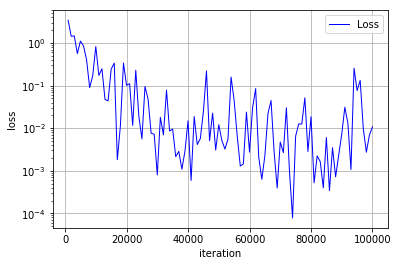

In [6]:
# Let's plot the training loss
train_data = np.loadtxt(LOG_DIR+'/training.txt')

fig, ax = plt.subplots(figsize=(6, 4))

ax.semilogy(train_data[:, 0], train_data[:, 1], 'b-', linewidth=1.0, label='Loss')

# tidy up the figure
ax.grid(True)
ax.legend(loc='upper right')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')

plt.show()

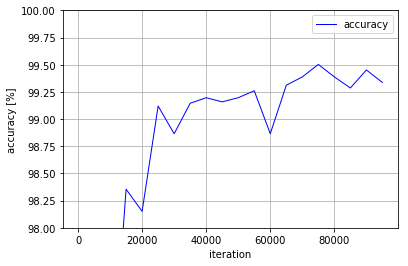

In [7]:
# Let's plot the validation accuracy
train_data = np.loadtxt(LOG_DIR+'/validation.txt')

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(train_data[:, 0], train_data[:, 2]*100, 'b-', linewidth=1.0, label='accuracy')

# tidy up the figure
ax.grid(True)
ax.legend(loc='upper right')
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy [%]')
ax.set_ylim(98,100)

plt.show()

### Improving the model
Now that we have a running model we can try and improve it by change different hyper-parameters or by modifying the architecture of the network. 

Q: Try and improve on the above accuracy by changing different parts of the model. What happens if another number of convolutionan layers are used per block? What happens if one uses residual connections? What happens when dropout is switched off? How does the number of base_channels affect the accuracy?

### Prediction

After model training and testing, we may want to actually deploy the model and let it run on unseen and unlabeled data, i.e. in prediction mode.

With Tensorflow estimators, we can call our trainied model in prediction mode.


In [ ]:
# call the prediction function. For simplicity, we do prediction on our validation samples
output = estimator.predict(input_fn(valid_set, mode=tf.estimator.ModeKeys.PREDICT))

# At this stage, the network has not actually executed!
# We need to loop over the returned 'output' generator to actually execute the network for the current sample.
for out in output:
    
    print ('Predicted class: {}'.format(out['prediction']))
                           
